<a href="https://colab.research.google.com/github/Sushmita9809/geospatial-python/blob/main/HSI_CLASSIFICATION_LEARNING_MODELS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**EFFECTIVE HYPERSPECTRAL IMAGE CLASSIFICATION USING LEARNING MODELS**

1. READING HYPERSPECTRAL IMAGE : INDIANPINES DATASET


In [1]:
from scipy.io import loadmat
## Read the data.
dataset = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
ground_truth = loadmat('Indian_pines_gt.mat')['indian_pines_gt']
print(f'Dataset: {dataset.shape}\nGround Truth: {ground_truth.shape}')

Dataset: (145, 145, 200)
Ground Truth: (145, 145)


2. HYPERSPECTRAL IMAGE  BAND VISUALIZATION


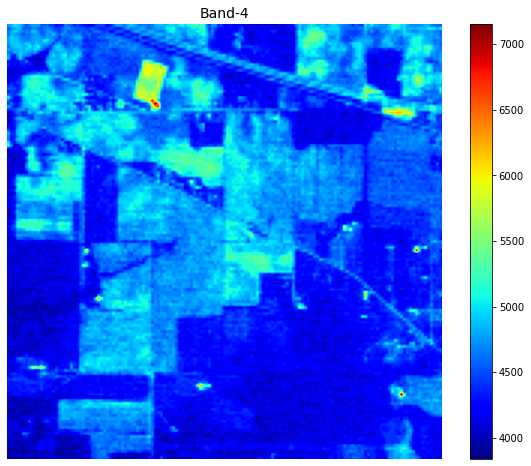

<Figure size 432x288 with 0 Axes>

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_band(dataset):
    plt.figure(figsize=(10, 8))
    band_no = np.random.randint(dataset.shape[2])
    plt.imshow(dataset[:,:, band_no], cmap='jet')
    plt.title(f'Band-{band_no}', fontsize=14)
    plt.axis('off')
    plt.colorbar()
    plt.show()
plot_band(dataset)
plt.savefig('hsi_visual.png')

3. GROUND TRUTH IMAGE VISUALIZATION

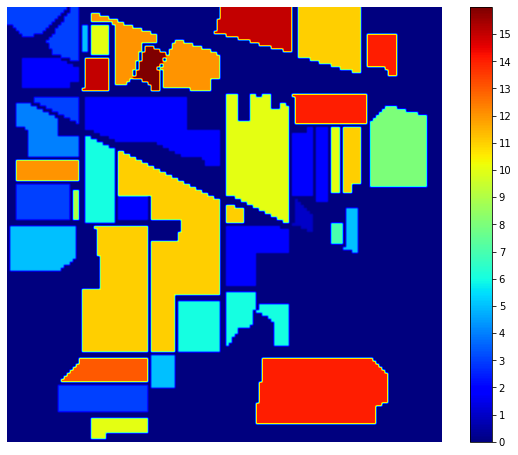

<Figure size 432x288 with 0 Axes>

In [4]:
plt.figure(figsize=(10, 8))
plt.imshow(ground_truth, cmap='jet')
plt.axis('off')
plt.colorbar(ticks= range(0,16))
plt.show()
plt.savefig('ground_truth_visual.png')

4. EXTRACT PIXELS FROM HYPERSPECTRAL IMAGE

In [6]:
!pip install tqdm

In [7]:
from tqdm import tqdm
import pandas as pd
def extract_pixels(dataset, ground_truth):
    df = pd.DataFrame()
    for i in tqdm(range(dataset.shape[2])):
        df = pd.concat([df, pd.DataFrame(dataset[:, :, i].ravel())], axis=1)
    df = pd.concat([df, pd.DataFrame(ground_truth.ravel())], axis=1)
    df.columns = [f'band-{i}' for i in range(1, 1+dataset.shape[2])]+['class']
    return df

In [8]:
df = extract_pixels(dataset, ground_truth)

100%|██████████| 200/200 [00:00<00:00, 309.68it/s]


In [9]:
df.head()

band-1  band-2  band-3  band-4  ...  band-198  band-199  band-200  class
0    3172    4142    4506    4279  ...      1057      1020      1020      3
1    2580    4266    4502    4426  ...      1064      1029      1020      3
2    3687    4266    4421    4498  ...      1061      1030      1016      3
3    2749    4258    4603    4493  ...      1060      1030      1006      3
4    2746    4018    4675    4417  ...      1052      1034      1019      3

[5 rows x 201 columns]

In [10]:
# Saving the data to a csv file.
df.to_csv('Dataset.csv', index=False)

5. SPECTRAL SIGNATURE VISUALIZATION

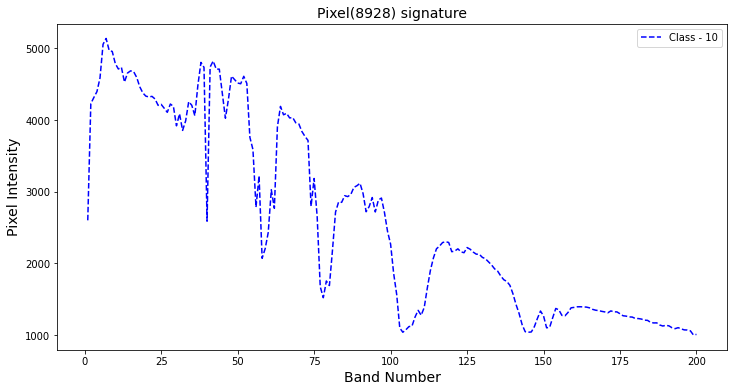

<Figure size 432x288 with 0 Axes>

In [12]:
def plot_signature(df):
    plt.figure(figsize=(12, 6))
    pixel_no = np.random.randint(df.shape[0])
    plt.plot(range(1, 201), df.iloc[pixel_no, :-1].values.tolist(), 'b--', label= f'Class - {df.iloc[pixel_no, -1]}')
    plt.legend()
    plt.title(f'Pixel({pixel_no}) signature', fontsize=14)
    plt.xlabel('Band Number', fontsize=14)
    plt.ylabel('Pixel Intensity', fontsize=14)
    plt.show()
plot_signature(df)
plt.savefig('spectral_signature_visual.png')

**PRINCIPAL COMPONENT ANALYSIS and SUPPORT VECTOR MACHINE on INDIAN PINES HSI**

In [13]:
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [14]:
!pip install hvplot
import hvplot
import hvplot.pandas

pd.options.plotting.backend = 'hvplot'

     |████████████████████████████████| 3.1 MB 7.8 MB/s 


1. READ DATA

In [15]:
df = pd.read_csv('Dataset.csv')

In [16]:
df.head()

band-1  band-2  band-3  band-4  ...  band-198  band-199  band-200  class
0    3172    4142    4506    4279  ...      1057      1020      1020      3
1    2580    4266    4502    4426  ...      1064      1029      1020      3
2    3687    4266    4421    4498  ...      1061      1030      1016      3
3    2749    4258    4603    4493  ...      1060      1030      1006      3
4    2746    4018    4675    4417  ...      1052      1034      1019      3

[5 rows x 201 columns]

In [17]:
X = df.iloc[:, :-1].values

y = df.iloc[:, -1].values

X.shape, y.shape

((21025, 200), (21025,))

2. PRINCIPAL COMPONENT ANALYSIS IMPLEMENTATION

In [18]:
#DIMENSION REDUCTION from 200 to 100.
pca = PCA(n_components = 100)

principalComponents = pca.fit_transform(X)

ev=pca.explained_variance_ratio_

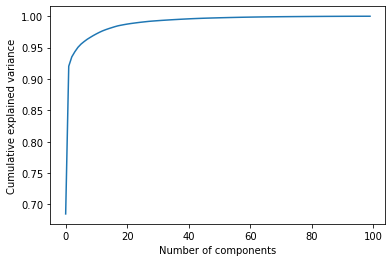

<Figure size 432x288 with 0 Axes>

In [19]:
#VISUALIZATION OF VARIANCE RATIO
plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()
plt.savefig('variance_ratio_explained.png')

In [20]:
#Dividing the reduced data into train and test
X_train, X_test, y_train, y_test, indices_train, indices_test  = train_test_split(principalComponents, y,  range(X.shape[0]), 
                                                                                  test_size = 0.15, random_state = 11)

X_train.shape, X_test.shape

((17871, 100), (3154, 100))

**2. SUPPORT VECTOR MACINES IMPLEMENTATION**

In [21]:
# SVM using Radial Basis Function(RBF) kernel.
svm = SVC(kernel='rbf', degree = 10, gamma='scale', cache_size=1024*7)
svm.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=7168, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=10, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [22]:
y_pred = svm.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(f'Accuracy: {accuracy_score(y_test, y_pred)}%')



Accuracy: 0.7238427393785669%


3. **CONFUSION MATRIX**

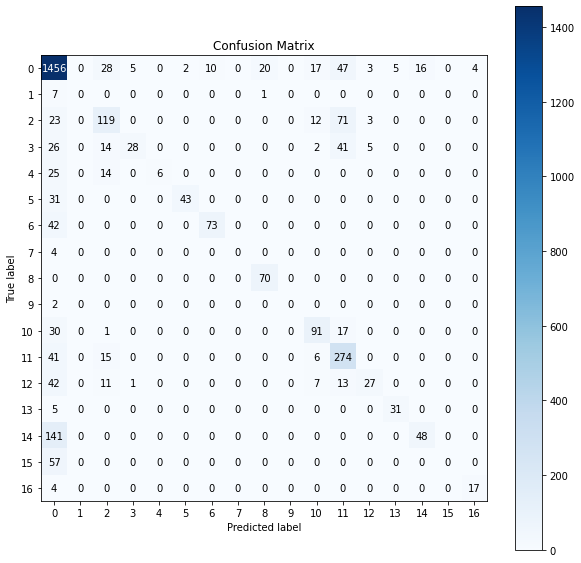

In [24]:
! pip install -q scikit-plot

import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    y_pred,
    figsize=(10,10));
plt.savefig('SVM_CONFUSION_MATRIX.png')

In [25]:
# print(confusion_matrix(y_test,y_pred))
print('Classification report:\n',classification_report(y_test,y_pred))

Classification report:
               precision    recall  f1-score   support

           0       0.75      0.90      0.82      1613
           1       0.00      0.00      0.00         8
           2       0.59      0.52      0.55       228
           3       0.82      0.24      0.37       116
           4       1.00      0.13      0.24        45
           5       0.96      0.58      0.72        74
           6       0.88      0.63      0.74       115
           7       0.00      0.00      0.00         4
           8       0.77      1.00      0.87        70
           9       0.00      0.00      0.00         2
          10       0.67      0.65      0.66       139
          11       0.59      0.82      0.69       336
          12       0.71      0.27      0.39       101
          13       0.86      0.86      0.86        36
          14       0.75      0.25      0.38       189
          15       0.00      0.00      0.00        57
          16       0.81      0.81      0.81        21

  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
plt.savefig('classification_report.png')

<Figure size 432x288 with 0 Axes>

**OA: 0.7238427393785669%**

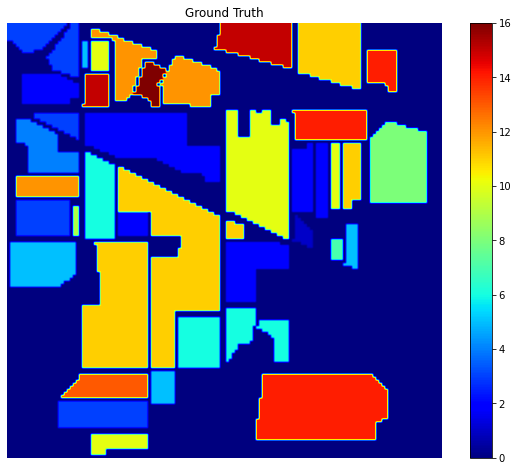

In [27]:
# Classification Map
plt.figure(figsize=(10, 8))
plt.imshow(df.iloc[:, -1].values.reshape((145, 145)), cmap='jet')
plt.colorbar()
plt.axis('off')
plt.title('Ground Truth')
plt.savefig('ground_truth.png')
plt.show()

In [28]:
pre = y_pred

clmap = [0]*X.shape[0]

for i in tqdm(range(len(indices_train))):
    clmap[indices_train[i]] = y[indices_train[i]]

for i in tqdm(range(len(indices_test))):
    clmap[indices_test[i]] = pre[i]

100%|██████████| 3154/3154 [00:00<00:00, 711418.92it/s]


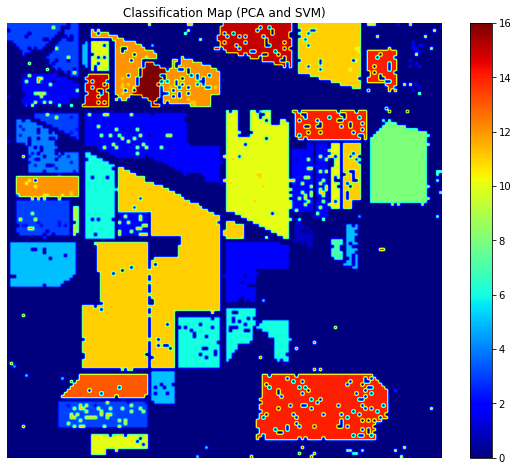

In [29]:
plt.figure(figsize=(10, 8))
plt.imshow(np.array(clmap).reshape((145, 145)), cmap='jet')
plt.colorbar()
plt.axis('off')
plt.title('Classification Map (PCA and SVM)')
plt.savefig('Classification_map.png')
plt.show()

# ** **HSI CLASSIFICATION USING CONVOLUTIONAL NEURAL NETWORK** **

In [30]:
!ls

Classification_map.png	    Indian_pines_gt.mat
classification_report.png   Indian_pines.mat
Dataset.csv		    sample_data
ground_truth.png	    spectral_signature_visual.png
ground_truth_visual.png     SVM_CONFUSION_MATRIX.png
hsi_visual.png		    variance_ratio_explained.png
Indian_pines_corrected.mat


In [31]:
!pip install earthpy

     |████████████████████████████████| 1.4 MB 6.2 MB/s 
     |████████████████████████████████| 1.0 MB 72.1 MB/s 
     |████████████████████████████████| 19.3 MB 1.4 MB/s 
     |████████████████████████████████| 6.3 MB 58.6 MB/s 
     |████████████████████████████████| 15.4 MB 39 kB/s 


In [32]:

import earthpy.plot as ep
import seaborn as sns
import earthpy.spatial as es

import plotly.graph_objects as go
import plotly.express as px

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tqdm import tqdm
from numpy.random import seed
from time import time

seed(11)

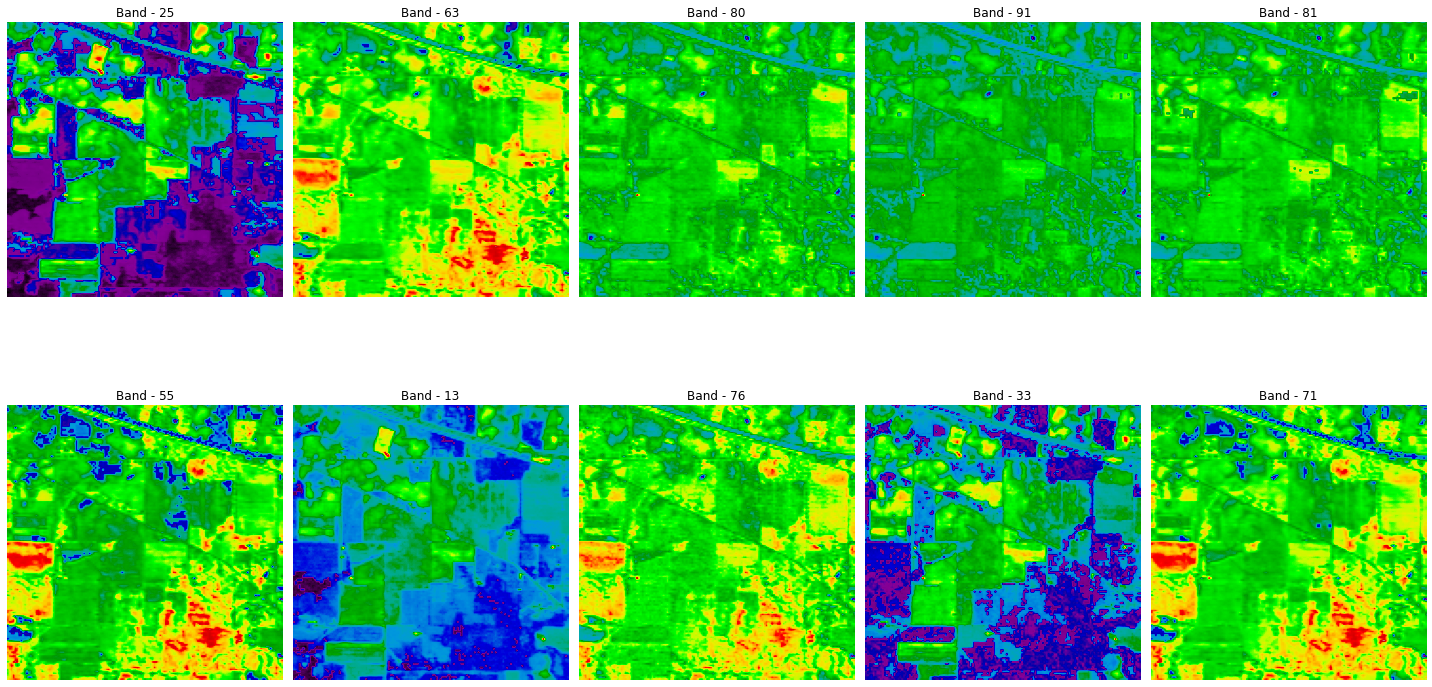

<Figure size 432x288 with 0 Axes>

In [33]:
#DATA VISUALIZATION
fig = plt.figure(figsize = (20, 12))

ax = fig.subplots(2, 5)

for i in range(2):
  for j in range(5):
    c = np.random.randint(103)
    ax[i][j].imshow(dataset[:, :, c], cmap='nipy_spectral')
    ax[i][j].axis('off')
    ax[i][j].title.set_text(f"Band - {c}")
    c+=1

plt.tight_layout()
plt.show()
plt.savefig('HSI_BANDS.png')

In [34]:
df = pd.DataFrame(dataset.reshape(dataset.shape[0]*dataset.shape[1], -1))

df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]

df['class'] = ground_truth.ravel()

In [35]:
#Scaling Data
t_df = df[df['class']!=0]

ind = ['band'+str(i) for i in range(1, t_df.shape[-1])]

X = t_df.loc[:, ind]

y = to_categorical(t_df.loc[:, 'class'])

X_scaled = minmax_scale(X, axis = 0);

X_scaled.shape, y.shape

((10249, 200), (10249, 17))

In [36]:
#Split Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    stratify=y, 
                                                    test_size=0.30)
print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (7174, 200)
y_train: (7174, 17)
X_test: (3075, 200)
y_test: (3075, 17)


**CNN network building**

In [37]:
ip_shape = X_train[1].shape

n_outputs = y_train.shape[1]

X_train[1].ravel().shape

(200,)

In [38]:
X_train = X_train.reshape(-1, 200, 1)
X_test = X_test.reshape(-1, 200, 1)

In [39]:
model = Sequential(name = 'INDIANPINES_CNN')

model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu', input_shape =(ip_shape[0],1), name = 'Layer1'))
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu' , name = 'Layer2'))
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu' , name = 'Layer3'))

model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_Layer1'))
model.add(Dropout(0.4, name = 'Dropout1'))

model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer4'))
model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer5'))
model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer6'))

model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_Layer2'))
model.add(Dropout(0.4, name = 'Dropout2'))

model.add(Flatten(name = 'Flatten'))

model.add(Dense(25, activation='relu', name = 'DenseLayer'))

model.add(Dense(n_outputs, activation='softmax', name = 'OutputLayer'))


model.summary()

Model: "INDIANPINES_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer1 (Conv1D)              (None, 198, 64)           256       
_________________________________________________________________
Layer2 (Conv1D)              (None, 196, 64)           12352     
_________________________________________________________________
Layer3 (Conv1D)              (None, 194, 64)           12352     
_________________________________________________________________
MaxPooling_Layer1 (MaxPoolin (None, 97, 64)            0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 97, 64)            0         
_________________________________________________________________
Layer4 (Conv1D)              (None, 95, 32)            6176      
_________________________________________________________________
Layer5 (Conv1D)              (None, 93, 32)        

In [40]:
with open('modelsummary.txt', 'w') as f:

    model.summary(print_fn=lambda x: f.write(x + '\n'))

Model: "INDIANPINES_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer1 (Conv1D)              (None, 198, 64)           256       
_________________________________________________________________
Layer2 (Conv1D)              (None, 196, 64)           12352     
_________________________________________________________________
Layer3 (Conv1D)              (None, 194, 64)           12352     
_________________________________________________________________
MaxPooling_Layer1 (MaxPoolin (None, 97, 64)            0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 97, 64)            0         
_________________________________________________________________
Layer4 (Conv1D)              (None, 95, 32)            6176      
_________________________________________________________________
Layer5 (Conv1D)              (None, 93, 32)        

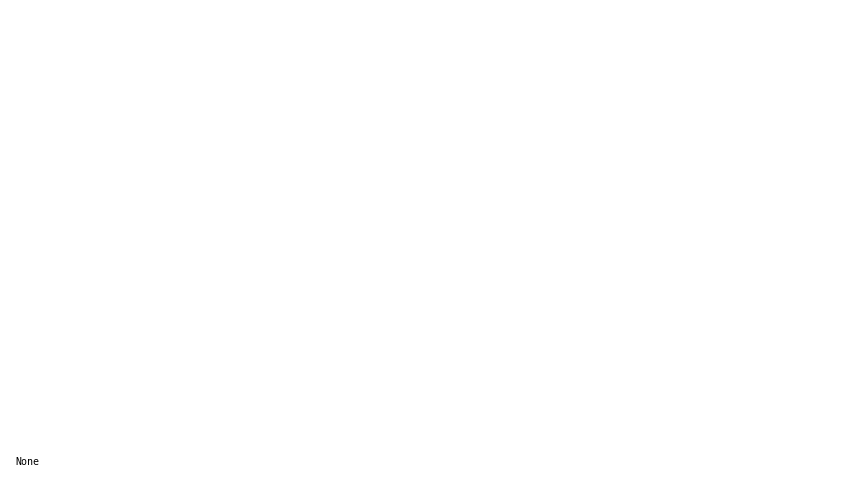

In [44]:

plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('output_model_Summary.png')

In [51]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
early_stop = EarlyStopping(monitor = 'val_loss',
                            mode = 'min',
                            min_delta = 0,
                            patience = 10,
                            restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'INDIAN_PINES_MODEL.h5', 
                             monitor = 'val_loss', 
                             mode ='min', 
                             save_best_only = True)

tensorboard = TensorBoard(log_dir='IP_logs/{}'.format(time()))

In [53]:
hist = model.fit(X_train, 
                       y_train, 
                       epochs = 100, 
                       batch_size = 256 , 
                       validation_data = (X_test, y_test), 
                       callbacks=[early_stop,
                                  checkpoint,
                                  tensorboard])

Epoch 1/100
29/29 [==============================] - 11s 332ms/step - loss: 2.4114 - accuracy: 0.2099 - val_loss: 2.0314 - val_accuracy: 0.2982
Epoch 2/100
29/29 [==============================] - 10s 334ms/step - loss: 1.8351 - accuracy: 0.3655 - val_loss: 1.6351 - val_accuracy: 0.4289
Epoch 3/100
29/29 [==============================] - 10s 333ms/step - loss: 1.5482 - accuracy: 0.4527 - val_loss: 1.3860 - val_accuracy: 0.5011
Epoch 4/100
29/29 [==============================] - 9s 319ms/step - loss: 1.3975 - accuracy: 0.4863 - val_loss: 1.3004 - val_accuracy: 0.5200
Epoch 5/100
29/29 [==============================] - 9s 319ms/step - loss: 1.3261 - accuracy: 0.5130 - val_loss: 1.2503 - val_accuracy: 0.5314
Epoch 6/100
29/29 [==============================] - 9s 318ms/step - loss: 1.2706 - accuracy: 0.5259 - val_loss: 1.1917 - val_accuracy: 0.5551
Epoch 7/100
29/29 [==============================] - 9s 321ms/step - loss: 1.2258 - accuracy: 0.5415 - val_loss: 1.2864 - val_accuracy: 0.5

In [54]:
loss, acc = model.evaluate(X_test, y_test)

97/97 [==============================] - 1s 11ms/step - loss: 0.5250 - accuracy: 0.8140


In [55]:
print(f"Accuracy: {acc*100}\nLoss: {loss}")

Accuracy: 81.39837384223938
Loss: 0.5250316858291626


In [56]:
from tensorflow.keras.models import load_model

model = load_model("INDIAN_PINES_MODEL.h5")

In [57]:
pred = np.argmax(model.predict(X_test), axis=1)

# Classification Report
print(classification_report(pred, np.argmax(y_test, 1),
      target_names = ['1.Alfalfa', '2.Corn-notill',
                      '3.Corn-mintill',
                      '4.Corn',
                      '5.Grass-pasture',
                      '6.Grass-trees',
                      '7.Grass-pasture-mowed',
                      '8.Hay-windrowed',
                      '9.Oats',
                      '10.Soybean-notill',
                      '11.Soybean-mintill',
                      '12.Soybean-clean',
                      '13.Wheat',
                      '14.Woods',
                      '15.Buildings-Grass-Trees-Drives',
                      '16.Stone-Steel-Towers']))

                                 precision    recall  f1-score   support

                      1.Alfalfa       0.79      0.85      0.81        13
                  2.Corn-notill       0.71      0.90      0.80       339
                 3.Corn-mintill       0.73      0.80      0.76       225
                         4.Corn       0.72      0.73      0.72        70
                5.Grass-pasture       0.92      0.87      0.90       154
                  6.Grass-trees       0.97      0.93      0.95       228
          7.Grass-pasture-mowed       0.62      1.00      0.77         5
                8.Hay-windrowed       0.98      0.97      0.98       144
                         9.Oats       1.00      0.86      0.92         7
              10.Soybean-notill       0.83      0.79      0.81       306
             11.Soybean-mintill       0.89      0.79      0.84       832
               12.Soybean-clean       0.82      0.81      0.82       180
                       13.Wheat       1.00      0.

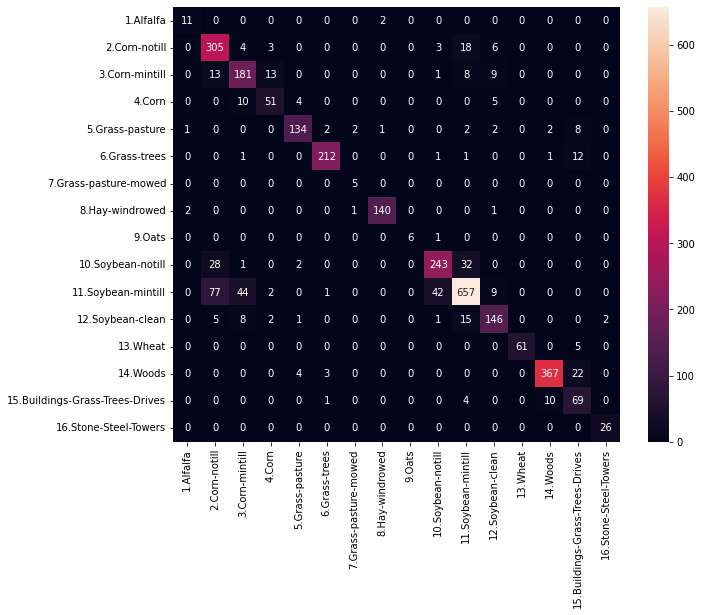

<Figure size 864x504 with 0 Axes>

In [59]:
plt.figure(figsize = (10,8))
classes = ['1.Alfalfa', '2.Corn-notill',
                      '3.Corn-mintill',
                      '4.Corn',
                      '5.Grass-pasture',
                      '6.Grass-trees',
                      '7.Grass-pasture-mowed',
                      '8.Hay-windrowed',
                      '9.Oats',
                      '10.Soybean-notill',
                      '11.Soybean-mintill',
                      '12.Soybean-clean',
                      '13.Wheat',
                      '14.Woods',
                      '15.Buildings-Grass-Trees-Drives',
                      '16.Stone-Steel-Towers']

mat = confusion_matrix(np.add(pred, 1), np.add(np.argmax(y_test, 1), 1))

df_cm = pd.DataFrame(mat, index = classes, columns = classes)

sns.heatmap(df_cm, annot=True, fmt='d')

plt.show()
plt.savefig('HSI_CNN_CONFUSION_MATRIX.png')